# **Estimating Mobility Flows for Leisure and Care**


---
## MSc Urban Spatial Science

Felipe Almeida

2023





**TO DO**



1.   Generate Flows for Work
2.   



# **Load Packages**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install geopandas==0.9.0 --quiet
!pip install scikit-mobility --quiet
!pip install area --quiet
!pip install rtree --quiet
!pip install pygeos --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 70.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.12.2 requires statsmodels>=0.14.0, but you have statsmodels 0.13.5 which is incompatible.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
%cd /content/drive/MyDrive/Colab/DeepGravity/deepgravity/


/content/drive/MyDrive/Colab/DeepGravity/deepgravity


# Leisure and Care Flow

In [ ]:
# !cp -r /content/drive/MyDrive/Colab/DeepGravity/data/london /content/drive/MyDrive/Colab/DeepGravity/deepgravity/data/london
# !mkdir /content/DeepGravity/deepgravity/data/london/processed

## **Initialisation**

In [5]:
from utils import _check_base_files, load_data
import pandas as pd
import json
import pickle
import torch
import os

import geopandas
from skmob.tessellation import tilers

def compute_support_files(
    db_dir,
    tile_id_column,
    tile_geometry,
    oa_id_column,
    oa_geometry,
    flow_origin_column,
    flow_destination_column,
    flow_flows_column,
):
    # first, we check if there are at least the needed files into the base directory.
    print('Generating the processed files - it may take a while....')
    print('Reading tessellation....')
    tessellation = geopandas.read_file(
        db_dir + '/grid7.json', dtype={tile_id_column: str}
    )
    tessellation = tessellation[[tile_id_column, tile_geometry]]
    print('Reading output areas....')
    output_areas = tessellation[[oa_id_column, oa_geometry]]
    print('Reading features....')
    try:
        features = pd.read_csv(db_dir + '/features.csv')
        if oa_id_column not in list(features.columns):
            raise ValueError(
                'Features must be associated with an output area. Please add a column '
                + +' to features.csv'
            )
    except:
        features = None
        print('Running without features. features.csv not found....')

    print('Mapping output areas with tessellation....')
    output_areas['centroid'] = output_areas[oa_geometry].centroid
    # prepare and write  oa_gdf.csv.gz
    output_areas['area_km2'] = output_areas[oa_geometry].area / 10**6
    output_areas['x'] = output_areas['centroid'].x
    output_areas['y'] = output_areas['centroid'].y
    output_areas['ctrs'] = (
        '[' + output_areas['x'].astype(str) + ',' + output_areas['y'].astype(str) + ']'
    )

    temp_out = output_areas[[oa_id_column, 'ctrs', 'area_km2']]
    temp_out.rename(
        columns={oa_id_column: 'geo_code', 'ctrs': 'centroid'}, inplace=True
    )

    temp_out.to_csv(db_dir + '/processed/oa_gdf.csv.gz')

    oa2centroid = {}
    for i, row in temp_out.iterrows():
        oa2centroid[row['geo_code']] = list(map(float, row['centroid'].strip('][').split(',')))

    with open(db_dir + '/processed/oa2centroid.pkl', 'wb') as handle:
        pickle.dump(oa2centroid, handle)

    output_areas.drop(columns=[oa_geometry], inplace=True)
    output_areas.rename(columns={'centroid': oa_geometry}, inplace=True)

    mapping = geopandas.sjoin(output_areas, tessellation, how='inner', op='within')
    try:
        mapping.drop(columns=['index_right'], inplace=True)
    except:
        pass

    flows = pd.read_csv(
        db_dir + '/flows.csv',
        dtype={
            flow_origin_column: str,
            flow_destination_column: str,
            flow_flows_column: int,
        },
    )
    flows = flows[[flow_origin_column, flow_destination_column, flow_flows_column]]

    flows.rename(
        columns={
            flow_origin_column: 'residence',
            flow_destination_column: 'workplace',
            flow_flows_column: 'commuters',
        },
        inplace=True,
    )
    flows.to_csv(db_dir + '/processed/flows_oa.csv.zip')

    od2flow = {}
    for i, row in flows.iterrows():
        od2flow[(row['residence'], row['workplace'])] = row['commuters']

    with open(db_dir + '/processed/od2flow.pkl', 'wb') as handle:
        pickle.dump(od2flow, handle)

    features = pd.read_csv(db_dir + '/features.csv', dtype={oa_id_column: str})
    features = features.iloc[:, 1:]
    oa2features = {}
    for i, row in features.iterrows():
        oa2features[row[0]] = list(row[1:].values)
    with open(db_dir + '/processed/oa2features.pkl', 'wb') as handle:
        pickle.dump(oa2features, handle)
    tileid2oa2handmade_features = dict()
    mapping = mapping.rename(columns={tile_id_column + '_left': tile_id_column})
    for i, row in features.iterrows():
        tileid2oa2handmade_features[row[tile_id_column]] = {}
        for item in zip(list(row.keys()), row.values):
            if item[0] != tile_id_column:
              tileid2oa2handmade_features[row[tile_id_column]][item[0]] = [item[1]]

    with open(db_dir + '/processed/tileid2oa2handmade_features.json', 'w') as f:
        json.dump(tileid2oa2handmade_features, f)

/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [6]:
db_dir =  'data/london'
compute_support_files(
    db_dir,
    tile_id_column='_index',
    tile_geometry='geometry',
    oa_id_column='_index',
    oa_geometry='geometry',
    flow_origin_column='ORIGIN_CODE',
    flow_destination_column='DESTINATION_CODE',
    flow_flows_column='FLOWS',
)

Generating the processed files - it may take a while....
Reading tessellation....
Reading output areas....
Reading features....
Mapping output areas with tessellation....


<ipython-input-5-ec4295ca260f>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_out.rename(
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
tileid2oa2features2vals, oa_gdf, flow_df, oa2pop, oa2features, od2flow, oa2centroid = load_data(
    'data/london',
    tile_id_column='_index',
    tile_geometry='geometry',
    oa_id_column='_index',
    oa_geometry='geometry',
    flow_origin_column='ORIGIN_CODE',
    flow_destination_column='DESTINATION_CODE',
    flow_flows_column='FLOWS',
)

/content/drive/MyDrive/Colab/DeepGravity/deepgravity/utils.py:151: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()


In [8]:
import torch
from typing import List, Dict, Tuple, Any
import numpy as np
from math import sqrt, sin, cos, pi, asin



def earth_distance(lat_lng1, lat_lng2):
    lat1, lng1 = [l * pi / 180. for l in lat_lng1]
    lat2, lng2 = [l * pi / 180. for l in lat_lng2]
    dlat, dlng = lat1 - lat2, lng1 - lng2
    ds = 2 * asin(
        sqrt(sin(dlat / 2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlng / 2.0) ** 2)
    )
    return 6371.01 * ds  # spherical earth...

class FlowDataset(torch.utils.data.Dataset):
    def __init__(self,
                 list_IDs: List[str],
                 tileid2oa2features2vals: Dict,
                 o2d2flow: Dict,
                 oa2features: Dict,
                 oa2pop: Dict,
                 oa2centroid: Dict,
                 dim_dests: int,
                 frac_true_dest: float,
                 model: str
                ) -> None:
        'Initialization'
        self.list_IDs = list_IDs
        self.tileid2oa2features2vals = tileid2oa2features2vals
        self.o2d2flow = o2d2flow
        self.oa2features = oa2features
        self.oa2pop = oa2pop
        self.oa2centroid = oa2centroid
        self.dim_dests = dim_dests
        self.frac_true_dest = frac_true_dest
        self.model = model
        self.oa2tile = {tile:tile for tile in list_IDs}

    def __len__(self) -> int:
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def get_features(self, oa_origin, oa_destination):
        oa2features = self.oa2features
        oa2centroid = self.oa2centroid
        dist_od = earth_distance(oa2centroid[oa_origin], oa2centroid[oa_destination])

        return oa2features[oa_origin] + oa2features[oa_destination] + [dist_od]

    def get_flow(self, oa_origin, oa_destination):
        o2d2flow = self.o2d2flow
        try:
            return o2d2flow[oa_origin][oa_destination]
        except KeyError:
            return 0

    def get_destinations(self, oa, size_train_dest, all_locs_in_train_region):
        o2d2flow = self.o2d2flow
        frac_true_dest = self.frac_true_dest
        try:
            true_dests_all = list(o2d2flow[oa].keys())
        except KeyError:
            true_dests_all = []
        size_true_dests = min(int(size_train_dest * frac_true_dest), len(true_dests_all))
        size_fake_dests = size_train_dest - size_true_dests

        true_dests = np.random.choice(true_dests_all, size=size_true_dests, replace=False)
        fake_dests_all = list(set(all_locs_in_train_region) - set(true_dests))
        fake_dests = np.random.choice(fake_dests_all, size=size_fake_dests, replace=False)

        dests = np.concatenate((true_dests, fake_dests))
        np.random.shuffle(dests)
        return dests

    def get_X_T(self, origin_locs, dest_locs):

        X, T = [], []
        for en, i in enumerate(origin_locs):
            X += [[]]
            T += [[]]
            for j in dest_locs[en]:
                X[-1] += [self.get_features(i, j)]
                T[-1] += [self.get_flow(i, j)]

        teX = torch.from_numpy(np.array(X)).float()
        teT = torch.from_numpy(np.array(T)).float()
        return teX, teT

    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        tileid2oa2features2vals = self.tileid2oa2features2vals
        dim_dests = self.dim_dests
        oa2tile = self.oa2tile

        # Select sample (tile)
        sampled_origins = [self.list_IDs[index]]
        tile_ID = sampled_origins[0]
        all_locs_in_train_region = list(filter(lambda x: x in self.oa2features, o2d2flow[tile_ID].keys()))
        size_train_dest = min(dim_dests, len(all_locs_in_train_region))
        sampled_dests = [self.get_destinations(oa, size_train_dest, all_locs_in_train_region)
                         for oa in sampled_origins]

        sampled_trX, sampled_trT = self.get_X_T(sampled_origins, sampled_dests)


        return sampled_trX, sampled_trT, sampled_origins
    def __getitem_tile__(self, index: int) -> Tuple[Any, Any]:
        'Generates one sample of data (one tile)'

        tileid2oa2features2vals = self.tileid2oa2features2vals
        dim_dests = self.dim_dests
        tile_ID = self.list_IDs[index]
        sampled_origins = list(tileid2oa2features2vals[tile_ID].keys())

        # Select a subset of OD pairs
        train_locs = sampled_origins
        all_locs_in_train_region = train_locs
        size_train_dest = min(dim_dests, len(all_locs_in_train_region))
        sampled_dests = [self.get_destinations(oa, size_train_dest, all_locs_in_train_region)
                         for oa in sampled_origins]

        # get the features and flows
        sampled_trX, sampled_trT = self.get_X_T(sampled_origins, sampled_dests)

        return sampled_trX, sampled_trT



class FlowPredDataset(FlowDataset):



    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        tileid2oa2features2vals = self.tileid2oa2features2vals
        dim_dests = self.dim_dests
        oa2tile = self.oa2tile

        # Select sample (tile)
        sampled_origins = [self.list_IDs[index]]
        tile_ID = sampled_origins[0]
        all_locs_in_train_region = list(filter(lambda x: x in self.oa2features, o2d2flow[tile_ID].keys()))
        size_train_dest = min(dim_dests, len(all_locs_in_train_region))
        sampled_dests = [self.get_destinations(oa, size_train_dest, all_locs_in_train_region)
                         for oa in sampled_origins]

        sampled_trX, sampled_trT = self.get_X_T(sampled_origins, sampled_dests)


        return sampled_trX, sampled_trT, sampled_origins, list(sampled_dests[0])

## Data

In [9]:

import pandas as pd
db_dir = 'data/london'
tileid2oa2features2vals, oa_gdf, flow_df, oa2pop, oa2features, od2flow, oa2centroid = load_data(
    db_dir,
    tile_id_column='_index',
    tile_geometry='geometry',
    oa_id_column='_index',
    oa_geometry='geometry',
    flow_origin_column='ORIGIN_CODE',
    flow_destination_column='DESTINATION_CODE',
    flow_flows_column='FLOWS',
)
o2d2flow = {}
for (o, d), f in od2flow.items():
    try:
        d2f = o2d2flow[o]
        d2f[d] = f
    except KeyError:
        o2d2flow[o] = {d: f}

train_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                      'o2d2flow': o2d2flow,
                      'oa2features': oa2features,
                      'oa2pop': oa2pop,
                      'oa2centroid': oa2centroid,
                      'dim_dests': 512,
                      'frac_true_dest': 0.0,
                      'model': 'DG'}

test_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                     'o2d2flow': o2d2flow,
                     'oa2features': oa2features,
                     'oa2pop': oa2pop,
                     'oa2centroid': oa2centroid,
                     'dim_dests': int(1e9),
                     'frac_true_dest': 0.0,
                     'model': 'DG'}

# datasets
from sklearn.model_selection import train_test_split
def collate_fn(batch):
    data = torch.cat([item[0].squeeze(0) for item in batch])
    target = torch.cat([item[1].squeeze(0) for item in batch])
    ids = [item[2] for item in batch]
    #target = torch.LongTensor(target)
    return [data.unsqueeze(0), target.unsqueeze(0)], ids
ids = list(filter(lambda x: x in oa2features, o2d2flow.keys()))
train_data, test_data = train_test_split(ids, test_size=0.3)
#train_data = pd.read_csv(db_dir + '/processed/train_tiles.csv', header=None, dtype=object)[0].values
#test_data = pd.read_csv(db_dir + '/processed/test_tiles.csv', header=None)[0].values
train_dataset = FlowDataset(train_data, **train_dataset_args)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn)

test_dataset = FlowPredDataset(test_data, **test_dataset_args)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)


dim_input = len(train_dataset.get_features(train_data[0], train_data[0]))

/content/drive/MyDrive/Colab/DeepGravity/deepgravity/utils.py:151: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()


## Train

In [10]:
import torch.optim as optim
import utils
import time

model = utils.instantiate_model(oa2centroid, oa2features, oa2pop, dim_input, device=torch.device('cuda'))
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=5e-6, momentum=0.9)

t0 = time.time()
n_epochs = 50
losses = []
for epoch in range(n_epochs):
  model.train()
  running_loss = 0.0
  training_acc = 0.0

  for batch_idx, ((b_data, b_target), ids) in enumerate(train_loader):
      if b_data.size(1) > 1:
        optimizer.zero_grad()
        loss = 0.0
        for data, target in zip(b_data, b_target):
            data, target = data.cuda(), target.cuda()
            output = model.forward(data).squeeze(-1)
            loss += model.loss(output.unsqueeze(0), target.unsqueeze(0))

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
  print('Train Epoch: {} [{}/{} \tLoss: {:.6f}'.format(epoch, epoch+1, n_epochs, running_loss/len(train_loader)))

  running_loss = running_loss / len(train_dataset)
  losses.append(running_loss)
  training_acc = training_acc / len(train_dataset)

t1 = time.time()
print("Total training time: %s seconds" % (t1 - t0))

fname = './results/model_DG_london.pt'
print('Saving model to {} ...'.format(fname))
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, fname)

Train Epoch: 0 [1/50 	Loss: 165335.495941
Train Epoch: 1 [2/50 	Loss: 146796.318663
Train Epoch: 2 [3/50 	Loss: 145114.804559
Train Epoch: 3 [4/50 	Loss: 141992.510617
Train Epoch: 4 [5/50 	Loss: 140208.356856
Train Epoch: 5 [6/50 	Loss: 138905.141682
Train Epoch: 6 [7/50 	Loss: 135970.647144
Train Epoch: 7 [8/50 	Loss: 134195.339356
Train Epoch: 8 [9/50 	Loss: 133409.325855
Train Epoch: 9 [10/50 	Loss: 132941.752396
Train Epoch: 10 [11/50 	Loss: 132505.587779
Train Epoch: 11 [12/50 	Loss: 131722.311293
Train Epoch: 12 [13/50 	Loss: 131273.396268
Train Epoch: 13 [14/50 	Loss: 131133.354762
Train Epoch: 14 [15/50 	Loss: 130612.637098
Train Epoch: 15 [16/50 	Loss: 130746.486013
Train Epoch: 16 [17/50 	Loss: 130472.682961
Train Epoch: 17 [18/50 	Loss: 130254.617251
Train Epoch: 18 [19/50 	Loss: 130268.182160
Train Epoch: 19 [20/50 	Loss: 130150.119002
Train Epoch: 20 [21/50 	Loss: 130094.909570
Train Epoch: 21 [22/50 	Loss: 130047.151193
Train Epoch: 22 [23/50 	Loss: 129879.679672
Train E

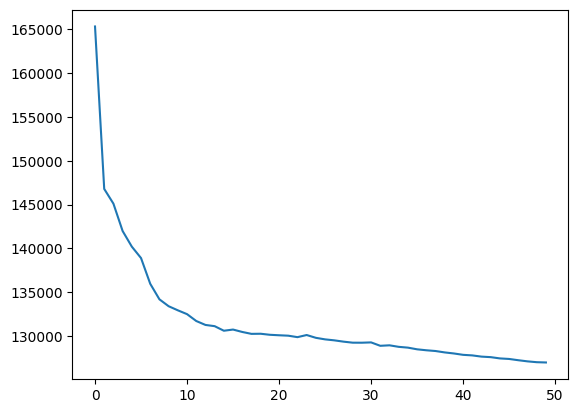

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses)

## Inference

In [12]:
dim_input = len(train_dataset.get_features(train_data[0], train_data[0]))
model = utils.instantiate_model(oa2centroid, oa2features, oa2pop, 37, device=torch.device('cuda'))

checkpoint = torch.load('./results/model_DG_london.pt')
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [13]:
loc2cpc_numerator = {}

model.eval()
result_df = pd.DataFrame()
with torch.no_grad():
    i = 0
    for batch_idx, (b_data, b_target, origin_ids, dest_ids) in enumerate(test_loader):
        for id, data, target in zip(origin_ids, b_data, b_target):
            data, target = data, target
            output = model.predict_proba(data)
        dest_ids = [d_id[0] for d_id in dest_ids]
        df = pd.DataFrame()
        target_flow = b_target[0].numpy()[0]
        total_flow = target_flow.sum()
        df['dest_ids'] = dest_ids
        df['proba'] = output[0]
        df['target'] = target_flow
        df['origin_ids'] = origin_ids[0][0]
        df['flow_prediction'] = (df['proba'] * total_flow).astype('int')
        result_df = pd.concat((result_df, df), ignore_index=True)
result_df[['origin_ids', 'dest_ids', 'proba', 'target', 'flow_prediction']]

,origin_ids,dest_ids,proba,target,flow_prediction
0,87195dadeffffff,87194ad09ffffff,0.001609,0.0,7
1,87195dadeffffff,87195dac8ffffff,0.001620,0.0,7
2,87195dadeffffff,87194ad53ffffff,0.000950,0.0,4
3,87195dadeffffff,87194e610ffffff,0.000874,0.0,4
4,87195dadeffffff,87195dad5ffffff,0.000891,46.0,4
...,...,...,...,...,...
51870,87195da66ffffff,87194e680ffffff,0.001188,0.0,59
51871,87195da66ffffff,87194e61cffffff,0.001522,0.0,76
51872,87195da66ffffff,87194e61affffff,0.001530,23.0,77
51873,87195da66ffffff,87194aca2ffffff,0.000710,0.0,35


In [ ]:
OD = pd.read_csv(path + 'OD_level7_nonwork_new.csv')

In [ ]:
OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,87194ac00ffffff,87194ac00ffffff,14496.0
1,87194ac00ffffff,87194ac01ffffff,736.0
2,87194ac00ffffff,87194ac02ffffff,483.0
3,87194ac00ffffff,87194ac03ffffff,1403.0
4,87194ac00ffffff,87194ac04ffffff,4255.0
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,0.0
172221,87195db6bffffff,87195db5cffffff,46.0
172222,87195db6bffffff,87195db5dffffff,0.0
172223,87195db6bffffff,87195db69ffffff,161.0


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(OD, *['FLOWS'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(OD, *['FLOWS'], **{})
chart

In [ ]:
df_final  = result_df[['origin_ids', 'dest_ids' ,'target']]
df_final.rename( columns= {'origin_ids': 'ORIGIN_CODE',
                          'dest_ids': 'DESTINATION_CODE'}, inplace=True )
df_final

<ipython-input-29-b204ce3df948>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename( columns= {'origin_ids': 'ORIGIN_CODE',


,ORIGIN_CODE,DESTINATION_CODE,target
0,87194e683ffffff,87194ad5affffff,0.0
1,87194e683ffffff,87195da41ffffff,0.0
2,87194e683ffffff,87195daddffffff,0.0
3,87194e683ffffff,87194ac31ffffff,0.0
4,87194e683ffffff,87194e6b6ffffff,0.0
...,...,...,...
48516,87195db4dffffff,87194e608ffffff,0.0
48517,87195db4dffffff,87194e603ffffff,0.0
48518,87195db4dffffff,87195daf5ffffff,0.0
48519,87195db4dffffff,87194ac10ffffff,0.0


In [ ]:
merge = pd.merge(df_final, OD, on=['ORIGIN_CODE', 'DESTINATION_CODE'], how= 'inner')

In [ ]:
merge

,ORIGIN_CODE,DESTINATION_CODE,target,FLOWS
0,87194e683ffffff,87194ad5affffff,0.0,0.0
1,87194e683ffffff,87195da41ffffff,0.0,0.0
2,87194e683ffffff,87195daddffffff,0.0,0.0
3,87194e683ffffff,87194ac31ffffff,0.0,0.0
4,87194e683ffffff,87194e6b6ffffff,0.0,0.0
...,...,...,...,...
48516,87195db4dffffff,87194e608ffffff,0.0,0.0
48517,87195db4dffffff,87194e603ffffff,0.0,0.0
48518,87195db4dffffff,87195daf5ffffff,0.0,0.0
48519,87195db4dffffff,87194ac10ffffff,0.0,0.0


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merge, *['target'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merge, *['FLOWS'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merge, *['target'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merge, *['FLOWS'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(merge, *[[['target', 'FLOWS']]], **{})
chart

## Result

In [14]:
import scipy.stats

def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""

    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2

    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""

    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)

    return RMSE

In [15]:
CalcRSquared(result_df["target"], result_df["flow_prediction"])

0.9022020537959151

In [16]:
CalcRMSE(result_df["target"],result_df["flow_prediction"])

336.713

In [17]:
path = '/content/drive/My Drive/Colab/'

In [18]:
DG_nonwork  = result_df[['origin_ids', 'dest_ids', 'flow_prediction']]
DG_nonwork.rename( columns= {'origin_ids': 'ORIGIN_CODE',
                          'dest_ids': 'DESTINATION_CODE',
                          'flow_prediction': 'flows'}, inplace=True )
DG_nonwork.to_csv(path + 'DG_nonwork.csv', index=False)

DG_nonwork

<ipython-input-18-a4773d538a36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DG_nonwork.rename( columns= {'origin_ids': 'ORIGIN_CODE',


,ORIGIN_CODE,DESTINATION_CODE,flows
0,87195dadeffffff,87194ad09ffffff,7
1,87195dadeffffff,87195dac8ffffff,7
2,87195dadeffffff,87194ad53ffffff,4
3,87195dadeffffff,87194e610ffffff,4
4,87195dadeffffff,87195dad5ffffff,4
...,...,...,...
51870,87195da66ffffff,87194e680ffffff,59
51871,87195da66ffffff,87194e61cffffff,76
51872,87195da66ffffff,87194e61affffff,77
51873,87195da66ffffff,87194aca2ffffff,35
